# Linear Regression

## Прогнозирование просмотров

In [1]:
import pandas as pd

df = pd.read_csv("growth_df_btw_ids.tsv", sep='\t')
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

Среди всех столбцов выделяем признаки – все численные характеристики, кроме стастических показателей за 7 дней.

In [2]:
import numpy as np

numeric_data = df.select_dtypes([np.number])
numeric_features = numeric_data.columns

features = [item for item in numeric_features if item[-1] != '7']

In [3]:
features

['category_id',
 'views_1',
 'views_2',
 'views_3',
 'views_4',
 'views_5',
 'views_6',
 'likes_1',
 'likes_2',
 'likes_3',
 'likes_4',
 'likes_5',
 'likes_6',
 'dislikes_1',
 'dislikes_2',
 'dislikes_3',
 'dislikes_4',
 'dislikes_5',
 'dislikes_6',
 'comments_1',
 'comments_2',
 'comments_3',
 'comments_4',
 'comments_5',
 'comments_6',
 'channel_video_cnt_1',
 'channel_video_cnt_2',
 'channel_video_cnt_3',
 'channel_video_cnt_4',
 'channel_video_cnt_5',
 'channel_video_cnt_6',
 'channel_views_1',
 'channel_views_2',
 'channel_views_3',
 'channel_views_4',
 'channel_views_5',
 'channel_views_6',
 'channel_subscribers_1',
 'channel_subscribers_2',
 'channel_subscribers_3',
 'channel_subscribers_4',
 'channel_subscribers_5',
 'channel_subscribers_6',
 'top_comment_likes_1',
 'top_comment_likes_2',
 'top_comment_likes_3',
 'top_comment_likes_4',
 'top_comment_likes_5',
 'top_comment_likes_6',
 'top_comment_replies_1',
 'top_comment_replies_2',
 'top_comment_replies_3',
 'top_comment_repl

В зависимости от задачи (подзадачи) таргеты будут разными.

In [4]:
target_4 = ["views_7", "comments_7", "likes_7", "dislikes_7"]
target_views = ["views_7"]
target_likes = ["likes_7"]
target_dislikes = ["dislikes_7"]
target_comments = ["dislikes_7"]

In [5]:
from sklearn.model_selection import train_test_split

X = df[features]
y = df[target_views]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter("ignore")
%matplotlib inline

sns.set(style="darkgrid")

Для решения задачи хотелось бы обучить линейную регрессию, необходимо найти признаки, "наиболее линейно" связанные с целевой переменной, иначе говоря, посмотреть на коэффициент корреляции Пирсона между признаками и таргетом.

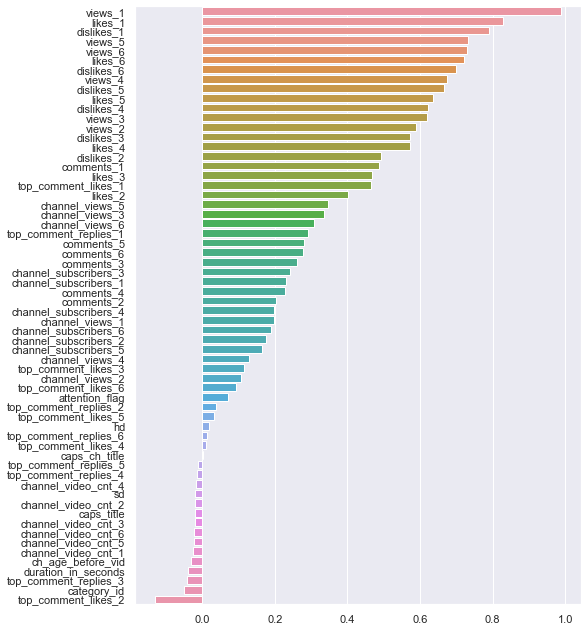

In [7]:
correlations_views = X_train.corrwith(y_train["views_7"]).sort_values(ascending=False)
plot_views = sns.barplot(y=correlations_views.index, x=correlations_views)
plot_views.figure.set_size_inches(8, 11)

В ходе экспериментов было выявлено, что лучшее качество модели достигается, если взять признаки с коэффициентом Пирсона не меньше 0.5.

Выделим наиболее важные признаки.

In [8]:
corr_df = pd.DataFrame(data={"features": correlations_views.index, "importance": correlations_views.values})
important_features = list(corr_df[np.abs(corr_df.importance) >= 0.5]["features"].values)
important_features

['views_1',
 'likes_1',
 'dislikes_1',
 'views_5',
 'views_6',
 'likes_6',
 'dislikes_6',
 'views_4',
 'dislikes_5',
 'likes_5',
 'dislikes_4',
 'views_3',
 'views_2',
 'dislikes_3',
 'likes_4']

In [9]:
X = df[important_features]
y = df[target_views]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

Подберём коэффициент регуляризации с помощью кросс-валидации.

In [10]:
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_std = scaler.fit_transform(X)
regr_cv = RidgeCV(alphas=list(np.arange(0.1, 10, 0.1)))
model_cv = regr_cv.fit(X_std, y)
cv_alpha = model_cv.alpha_

In [11]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

model = Ridge(alpha=cv_alpha)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))
print("Train RMSE = %.4f" % mean_squared_error(y_train, y_train_pred, squared=False))

Test RMSE = 40584.8977
Train RMSE = 29120.4099


In [94]:
y_all_pred = model.predict(X)
np.int64(y_all_pred)

array([[ 970458],
       [1180731],
       [  88790],
       ...,
       [ 448969],
       [ 675003],
       [3347950]])

In [95]:
fc = (pd.DataFrame(np.int64(y_all_pred), columns=["views_forecast"]))

In [96]:
pd.DataFrame(fc["views_forecast"].values, columns=["views_forecast"])

,views_forecast
0,970458
1,1180731
2,88790
3,477843
4,80278
...,...
7523,52169
7524,891716
7525,448969
7526,675003


In [97]:
df_copy = df.copy()
df_copy = df_copy.assign(views_forecast=pd.Series(fc["views_forecast"].values))

In [99]:
df_copy[["video_id", "views_7", "views_forecast"]].sample(10)

,video_id,views_7,views_forecast
5255,-b6SR4PzvIk,355680.0,357208
1231,drJ7D178dkE,785672.0,786678
3906,EVBCh_jtsTY,926502.0,928129
6412,laAbLsErZrw,4758572.0,4713270
1976,-y91hkAUB_A,1852270.0,1860713
2804,_6S3cBJ5Eqg,2885578.0,2887865
132,SgFiWTl82Vo,4630022.0,4618681
4250,IEkYH2jn-Ro,188701.0,189476
4498,FwWtOa5l7aQ,110566.0,111879
2297,92LUGwC4Sec,174852.0,175722


Подберём коэффициент регуляризации по сетке с помощью кросс-валидации.

Best alpha = 0.1129


Text(0, 0.5, 'CV score')

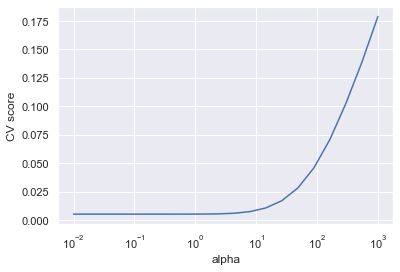

In [14]:
from sklearn.model_selection import GridSearchCV

alphas = np.logspace(-2, 3, 20)
searcher = GridSearchCV(Ridge(), [{"alpha": alphas}], scoring="neg_root_mean_squared_error", cv=10)
searcher.fit(X_train_scaled, y_train_scaled)

best_alpha = searcher.best_params_["alpha"]
print("Best alpha = %.4f" % best_alpha)

plt.plot(alphas, -searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score")

Попробуем улучшить качество модели, стандартизируя признаки и целевую переменную.

In [15]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train_scaled = scaler.fit_transform(y_train)
y_test_scaled = scaler.transform(y_test)

In [16]:
model = Ridge(alpha=best_alpha)
model.fit(X_train_scaled, y_train_scaled)
y_pred = model.predict(X_test_scaled)
y_train_pred = model.predict(X_train_scaled)

print("Test RMSE = %.4f" % mean_squared_error(y_test_scaled, y_pred, squared=False))
print("Train RMSE = %.4f" % mean_squared_error(y_train_scaled, y_train_pred, squared=False))
print("Test MSE = %.8f" % mean_squared_error(y_test_scaled, y_pred, squared=True))
print("Train MSE = %.8f" % mean_squared_error(y_train_scaled, y_train_pred, squared=True))

Test RMSE = 0.0051
Train RMSE = 0.0037
Test MSE = 0.00002620
Train MSE = 0.00001351


In [17]:
from sklearn.metrics import mean_absolute_error

print("Test MAE = %.8f" % mean_absolute_error(y_test_scaled, y_pred))

Test MAE = 0.00115930


In [124]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_test_scaled, y_pred)

1.7547208326489938

In [125]:
from sklearn.metrics import r2_score

r2_score(y_test_scaled, y_pred)

0.9999622316368325

In [135]:
mean_absolute_percentage_error(y_test_scaled, y_pred)

1.7547208326489938

In [18]:
model

Ridge(alpha=0.11288378916846889, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

Чтобы увидеть прогнозы, перейдём к исходной шкале.

In [21]:
model.coef_

array([[ 8.76527683e-01, -3.23773599e-04,  4.54636246e-04,
         4.97786328e-02,  4.69742220e-02,  4.15039715e-03,
         1.04438088e-02,  2.49650805e-02, -2.68834474e-02,
         6.00294627e-03,  1.04337772e-02,  3.64671380e-02,
         4.15729751e-02,  4.19956656e-03, -9.64720110e-03]])

In [127]:
y_inverse = scaler.inverse_transform(y_pred)

In [128]:
y_inverse

array([[ 195569.67963629],
       [2744008.69739133],
       [3468827.84417008],
       ...,
       [ 169710.83838779],
       [  83724.04145174],
       [ 386078.51741831]])

In [129]:
y_inverse = np.int64(y_inverse)

In [130]:
print("Test MSE = %.8f" % mean_squared_error(y_test, y_inverse, squared=True))

Test MSE = 1644543158.78308988


In [133]:
mean_absolute_percentage_error(y_test, y_inverse)

0.9183014168691738

In [134]:
r2_score(y_test, y_inverse)

0.9999622316108728

In [237]:
pd.DataFrame(y_inverse, columns=["views_forecast"])

,views_forecast
0,195569
1,2744008
2,3468827
3,1358079
4,1028630
...,...
2254,641160
2255,2104040
2256,169710
2257,83724


Получим предсказания просмотров по всем видео.

In [238]:
df_scaler = StandardScaler()
X_scaled = df_scaler.fit_transform(X)
y_scaled = df_scaler.fit_transform(y)

In [239]:
y_all_pred = model.predict(X_scaled)
y_all_pred

array([[-0.14140077],
       [-0.11343954],
       [-0.2578315 ],
       ...,
       [-0.2102281 ],
       [-0.18046356],
       [ 0.17235431]])

In [240]:
y_all_pred.shape

(7528, 1)

In [241]:
y_inv = df_scaler.inverse_transform(y_all_pred)

In [242]:
pd.DataFrame(np.int64(y_inv), columns=["views_forecast"])

,views_forecast
0,974258
1,1185378
2,95152
3,482786
4,86686
...,...
7523,58702
7524,894163
7525,454580
7526,679316


In [243]:
forecast_ = pd.DataFrame(np.int64(y_inv), columns=["views_forecast"])

In [244]:
forecast_["views_forecast"].values

array([ 974258, 1185378,   95152, ...,  454580,  679316, 3343254])

In [245]:
df_copy = df.copy()
df_copy = df_copy.assign(forecast=pd.Series(forecast_["views_forecast"].values))

In [246]:
df_copy[["video_id", "views_7", "forecast"]]

,video_id,views_7,forecast
0,HfGRNUOqhLk,968037.0,974258
1,Kk5naOEL3gQ,1160808.0,1185378
2,4bKuBuPB_QA,88263.0,95152
3,eYOIhHu2gho,476710.0,482786
4,0NDPSeDiYBI,79032.0,86686
...,...,...,...
7523,vlasHLCqsEQ,51014.0,58702
7524,pl4jSXEp-8w,895103.0,894163
7525,uiaTjPsnE5k,450749.0,454580
7526,cuHvxIy-CDc,673207.0,679316


## Прогнозирование лайков

Повторим процедуру для лайков. Точно так же будем определять значение коэффициента Пирсона, при котором отобранные признаки дают наилучшее качество модели.

In [22]:
import pandas as pd

df = pd.read_csv("growth_df_btw_ids.tsv", sep='\t')
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

Среди всех столбцов выделяем признаки – все численные характеристики, кроме стастических показателей за 7 дней.

In [23]:
import numpy as np

numeric_data = df.select_dtypes([np.number])
numeric_features = numeric_data.columns

features = [item for item in numeric_features if item[-1] != '7']

In [24]:
features

['category_id',
 'views_1',
 'views_2',
 'views_3',
 'views_4',
 'views_5',
 'views_6',
 'likes_1',
 'likes_2',
 'likes_3',
 'likes_4',
 'likes_5',
 'likes_6',
 'dislikes_1',
 'dislikes_2',
 'dislikes_3',
 'dislikes_4',
 'dislikes_5',
 'dislikes_6',
 'comments_1',
 'comments_2',
 'comments_3',
 'comments_4',
 'comments_5',
 'comments_6',
 'channel_video_cnt_1',
 'channel_video_cnt_2',
 'channel_video_cnt_3',
 'channel_video_cnt_4',
 'channel_video_cnt_5',
 'channel_video_cnt_6',
 'channel_views_1',
 'channel_views_2',
 'channel_views_3',
 'channel_views_4',
 'channel_views_5',
 'channel_views_6',
 'channel_subscribers_1',
 'channel_subscribers_2',
 'channel_subscribers_3',
 'channel_subscribers_4',
 'channel_subscribers_5',
 'channel_subscribers_6',
 'top_comment_likes_1',
 'top_comment_likes_2',
 'top_comment_likes_3',
 'top_comment_likes_4',
 'top_comment_likes_5',
 'top_comment_likes_6',
 'top_comment_replies_1',
 'top_comment_replies_2',
 'top_comment_replies_3',
 'top_comment_repl

В зависимости от задачи (подзадачи) таргеты будут разными.

In [25]:
target_4 = ["views_7", "comments_7", "likes_7", "dislikes_7"]
target_views = ["views_7"]
target_likes = ["likes_7"]
target_dislikes = ["dislikes_7"]
target_comments = ["dislikes_7"]

In [26]:
from sklearn.model_selection import train_test_split

X = df[features]
y = df[target_likes]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter("ignore")
%matplotlib inline

sns.set(style="darkgrid")

Для решения задачи хотелось бы обучить линейную регрессию, необходимо найти признаки, "наиболее линейно" связанные с целевой переменной, иначе говоря, посмотреть на коэффициент корреляции Пирсона между признаками и таргетом.

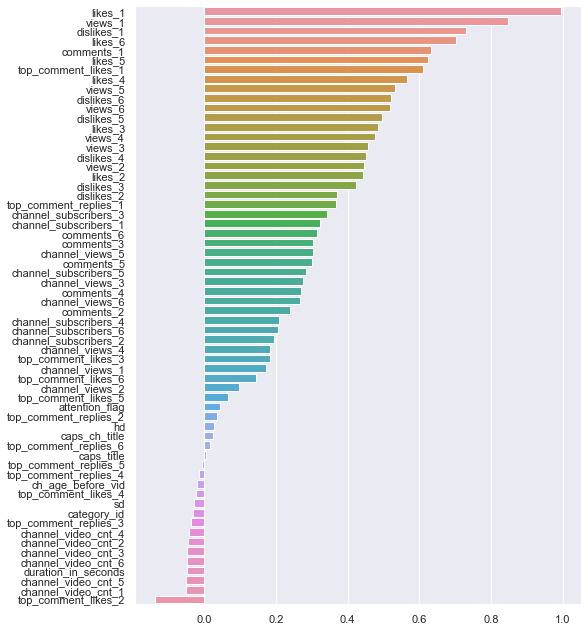

In [28]:
correlations_likes = X_train.corrwith(y_train["likes_7"]).sort_values(ascending=False)
plot_likes = sns.barplot(y=correlations_likes.index, x=correlations_likes)
plot_likes.figure.set_size_inches(8, 11)

В ходе экспериментов было выявлено, что лучшее качество модели достигается, если взять признаки с коэффициентом Пирсона не меньше 0.5.

Выделим наиболее важные признаки.

In [29]:
corr_df = pd.DataFrame(data={"features": correlations_likes.index, "importance": correlations_likes.values})
important_features = list(corr_df[np.abs(corr_df.importance) >= 0.4]["features"].values)
important_features

['likes_1',
 'views_1',
 'dislikes_1',
 'likes_6',
 'comments_1',
 'likes_5',
 'top_comment_likes_1',
 'likes_4',
 'views_5',
 'dislikes_6',
 'views_6',
 'dislikes_5',
 'likes_3',
 'views_4',
 'views_3',
 'dislikes_4',
 'views_2',
 'likes_2',
 'dislikes_3']

In [30]:
X = df[important_features]
y = df[target_likes]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

Подберём коэффициент регуляризации с помощью кросс-валидации.

In [31]:
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_std = scaler.fit_transform(X)
regr_cv = RidgeCV(alphas=list(np.arange(0.1, 10, 0.1)))
model_cv = regr_cv.fit(X_std, y)
cv_alpha = model_cv.alpha_

In [32]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

model = Ridge(alpha=cv_alpha)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))
print("Train RMSE = %.4f" % mean_squared_error(y_train, y_train_pred, squared=False))

Test RMSE = 883.8155
Train RMSE = 801.2634


Подберём коэффициент регуляризации по сетке с помощью кросс-валидации.

In [33]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train_scaled = scaler.fit_transform(y_train)
y_test_scaled = scaler.transform(y_test)

Best alpha = 0.0100


Text(0, 0.5, 'CV score')

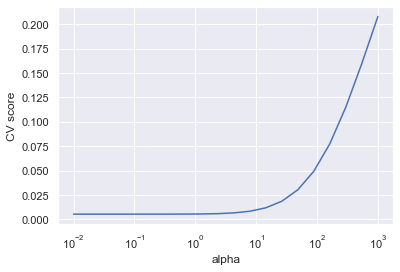

In [34]:
from sklearn.model_selection import GridSearchCV

alphas = np.logspace(-2, 3, 20)
searcher = GridSearchCV(Ridge(), [{"alpha": alphas}], scoring="neg_root_mean_squared_error", cv=10)
searcher.fit(X_train_scaled, y_train_scaled)

best_alpha = searcher.best_params_["alpha"]
print("Best alpha = %.4f" % best_alpha)

plt.plot(alphas, -searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score")

Попробуем улучшить качество модели, стандартизируя признаки и целевую переменную.

In [35]:
model = Ridge(alpha=best_alpha)
model.fit(X_train_scaled, y_train_scaled)
y_pred = model.predict(X_test_scaled)
y_train_pred = model.predict(X_train_scaled)

print("Test RMSE = %.4f" % mean_squared_error(y_test_scaled, y_pred, squared=False))
print("Train RMSE = %.4f" % mean_squared_error(y_train_scaled, y_train_pred, squared=False))
print("Test MSE = %.8f" % mean_squared_error(y_test_scaled, y_pred, squared=True))
print("Train MSE = %.8f" % mean_squared_error(y_train_scaled, y_train_pred, squared=True))

Test RMSE = 0.0033
Train RMSE = 0.0030
Test MSE = 0.00001116
Train MSE = 0.00000918


In [36]:
model

Ridge(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [37]:
model.coef_

array([[ 9.38348978e-01, -8.16105469e-04,  1.30858621e-03,
         2.74077925e-02, -2.39059432e-04,  2.54433537e-02,
        -1.46385077e-04,  9.73943321e-03,  1.24563136e-03,
         5.10550460e-04,  1.69919937e-03, -1.18920305e-02,
         2.49935300e-02,  8.39966759e-04, -3.68882141e-03,
         4.51126419e-03,  4.92003512e-04,  3.28813787e-02,
         4.70290323e-03]])

Чтобы увидеть прогнозы, перейдём к исходной шкале.

In [17]:
y_inverse = scaler.inverse_transform(y_pred)

In [18]:
y_inverse

array([[   502.83912007],
       [201230.70127871],
       [ 67915.67240212],
       ...,
       [ 14962.54758579],
       [  2196.52852956],
       [ 37382.11767529]])

In [19]:
y_inverse = np.int64(y_inverse)

In [21]:
from sklearn.metrics import r2_score

r2_score(y_test, y_inverse)

0.9999878084487095

In [22]:
pd.DataFrame(y_inverse, columns=["likes_forecast"])

,likes_forecast
0,502
1,201230
2,67915
3,6184
4,24202
...,...
2254,3978
2255,14980
2256,14962
2257,2196


Получим предсказания просмотров по всем видео.

In [365]:
df_scaler = StandardScaler()
X_scaled = df_scaler.fit_transform(X)
y_scaled = df_scaler.fit_transform(y)

In [366]:
y_all_pred = model.predict(X_scaled)
y_all_pred

array([[ 0.16063687],
       [-0.11892785],
       [-0.25894286],
       ...,
       [-0.25299223],
       [-0.21299682],
       [ 0.56875904]])

In [367]:
y_all_pred.shape

(7528, 1)

In [368]:
y_inv = df_scaler.inverse_transform(y_all_pred)

In [369]:
pd.DataFrame(np.int64(y_inv), columns=["likes_forecast"])

,likes_forecast
0,112370
1,39361
2,2796
3,8016
4,2298
...,...
7523,1328
7524,34843
7525,4350
7526,14794


In [370]:
forecast_ = pd.DataFrame(np.int64(y_inv), columns=["likes_forecast"])

In [371]:
forecast_["likes_forecast"].values

array([112370,  39361,   2796, ...,   4350,  14794, 218952])

In [374]:
df_copy = df.copy()
df_copy = df_copy.assign(likes_forecast=pd.Series(forecast_["likes_forecast"].values))

In [376]:
df_copy[["video_id", "likes_7", "likes_forecast"]]

,video_id,likes_7,likes_forecast
0,HfGRNUOqhLk,115973.0,112370
1,Kk5naOEL3gQ,40100.0,39361
2,4bKuBuPB_QA,2633.0,2796
3,eYOIhHu2gho,7065.0,8016
4,0NDPSeDiYBI,2072.0,2298
...,...,...,...
7523,vlasHLCqsEQ,1083.0,1328
7524,pl4jSXEp-8w,35300.0,34843
7525,uiaTjPsnE5k,3968.0,4350
7526,cuHvxIy-CDc,14225.0,14794


## Прогнозирование дизлайков

Аналогично для дизлайков.

In [38]:
import pandas as pd

df = pd.read_csv("growth_df_btw_ids.tsv", sep='\t')
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

Среди всех столбцов выделяем признаки – все численные характеристики, кроме стастических показателей за 7 дней.

In [39]:
import numpy as np

numeric_data = df.select_dtypes([np.number])
numeric_features = numeric_data.columns

features = [item for item in numeric_features if item[-1] != '7']

In [40]:
features

['category_id',
 'views_1',
 'views_2',
 'views_3',
 'views_4',
 'views_5',
 'views_6',
 'likes_1',
 'likes_2',
 'likes_3',
 'likes_4',
 'likes_5',
 'likes_6',
 'dislikes_1',
 'dislikes_2',
 'dislikes_3',
 'dislikes_4',
 'dislikes_5',
 'dislikes_6',
 'comments_1',
 'comments_2',
 'comments_3',
 'comments_4',
 'comments_5',
 'comments_6',
 'channel_video_cnt_1',
 'channel_video_cnt_2',
 'channel_video_cnt_3',
 'channel_video_cnt_4',
 'channel_video_cnt_5',
 'channel_video_cnt_6',
 'channel_views_1',
 'channel_views_2',
 'channel_views_3',
 'channel_views_4',
 'channel_views_5',
 'channel_views_6',
 'channel_subscribers_1',
 'channel_subscribers_2',
 'channel_subscribers_3',
 'channel_subscribers_4',
 'channel_subscribers_5',
 'channel_subscribers_6',
 'top_comment_likes_1',
 'top_comment_likes_2',
 'top_comment_likes_3',
 'top_comment_likes_4',
 'top_comment_likes_5',
 'top_comment_likes_6',
 'top_comment_replies_1',
 'top_comment_replies_2',
 'top_comment_replies_3',
 'top_comment_repl

В зависимости от задачи (подзадачи) таргеты будут разными.

In [41]:
target_4 = ["views_7", "comments_7", "likes_7", "dislikes_7"]
target_views = ["views_7"]
target_likes = ["likes_7"]
target_dislikes = ["dislikes_7"]
target_comments = ["comments_7"]

In [42]:
from sklearn.model_selection import train_test_split

X = df[features]
y = df[target_dislikes]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter("ignore")
%matplotlib inline

sns.set(style="darkgrid")

Для решения задачи хотелось бы обучить линейную регрессию, необходимо найти признаки, "наиболее линейно" связанные с целевой переменной, иначе говоря, посмотреть на коэффициент корреляции Пирсона между признаками и таргетом.

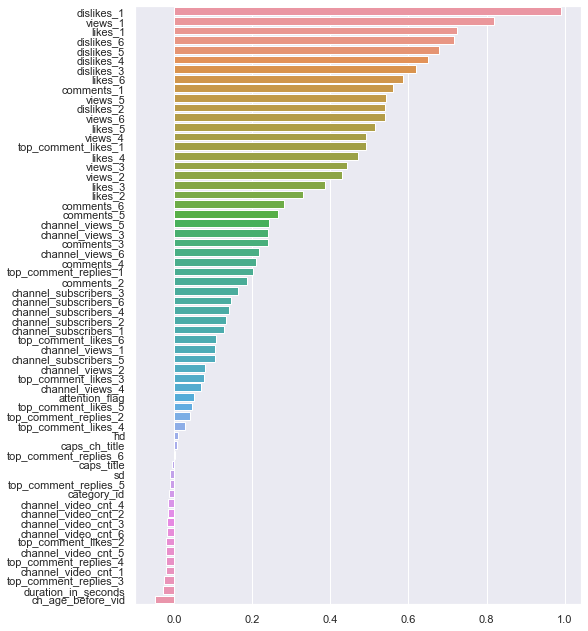

In [44]:
correlations_dislikes = X_train.corrwith(y_train["dislikes_7"]).sort_values(ascending=False)
plot_dislikes = sns.barplot(y=correlations_dislikes.index, x=correlations_dislikes)
plot_dislikes.figure.set_size_inches(8, 11)

В ходе экспериментов было выявлено, что лучшее качество модели достигается, если взять признаки с коэффициентом Пирсона не меньше 0.5.

Выделим наиболее важные признаки.

In [45]:
corr_df = pd.DataFrame(data={"features": correlations_dislikes.index, "importance": correlations_dislikes.values})
important_features = list(corr_df[np.abs(corr_df.importance) >= 0.4]["features"].values)
important_features

['dislikes_1',
 'views_1',
 'likes_1',
 'dislikes_6',
 'dislikes_5',
 'dislikes_4',
 'dislikes_3',
 'likes_6',
 'comments_1',
 'views_5',
 'dislikes_2',
 'views_6',
 'likes_5',
 'views_4',
 'top_comment_likes_1',
 'likes_4',
 'views_3',
 'views_2']

In [46]:
X = df[important_features]
y = df[target_dislikes]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

Подберём коэффициент регуляризации с помощью кросс-валидации.

In [47]:
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_std = scaler.fit_transform(X)
regr_cv = RidgeCV(alphas=list(np.arange(0.1, 10, 0.1)))
model_cv = regr_cv.fit(X_std, y)
cv_alpha = model_cv.alpha_

In [48]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

model = Ridge(alpha=cv_alpha)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))
print("Train RMSE = %.4f" % mean_squared_error(y_train, y_train_pred, squared=False))

Test RMSE = 93.0061
Train RMSE = 51.1400


Подберём коэффициент регуляризации по сетке с помощью кросс-валидации.

Best alpha = 0.0100


Text(0, 0.5, 'CV score')

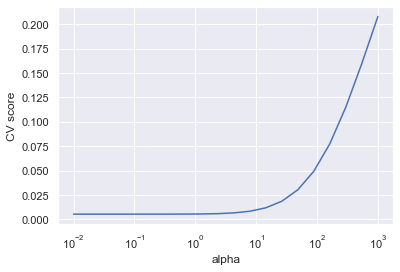

In [49]:
from sklearn.model_selection import GridSearchCV

alphas = np.logspace(-2, 3, 20)
searcher = GridSearchCV(Ridge(), [{"alpha": alphas}], scoring="neg_root_mean_squared_error", cv=10)
searcher.fit(X_train_scaled, y_train_scaled)

best_alpha = searcher.best_params_["alpha"]
print("Best alpha = %.4f" % best_alpha)

plt.plot(alphas, -searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score")

Попробуем улучшить качество модели, стандартизируя признаки и целевую переменную.

In [50]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train_scaled = scaler.fit_transform(y_train)
y_test_scaled = scaler.transform(y_test)

In [51]:
model = Ridge(alpha=best_alpha)
model.fit(X_train_scaled, y_train_scaled)
y_pred = model.predict(X_test_scaled)
y_train_pred = model.predict(X_train_scaled)

print("Test RMSE = %.4f" % mean_squared_error(y_test_scaled, y_pred, squared=False))
print("Train RMSE = %.4f" % mean_squared_error(y_train_scaled, y_train_pred, squared=False))
print("Test MSE = %.8f" % mean_squared_error(y_test_scaled, y_pred, squared=True))
print("Train MSE = %.8f" % mean_squared_error(y_train_scaled, y_train_pred, squared=True))

Test RMSE = 0.0064
Train RMSE = 0.0035
Test MSE = 0.00004106
Train MSE = 0.00001242


In [52]:
model

Ridge(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [53]:
model.coef_

array([[ 9.00925557e-01, -1.62697776e-03,  8.59149797e-04,
         4.59619870e-02,  3.12903898e-03,  4.11405094e-02,
         3.29635179e-02, -3.62026279e-03, -6.20059561e-04,
         2.41324460e-03,  4.68339444e-02,  4.95262805e-03,
         1.62788017e-02,  5.74304335e-04, -3.54687020e-04,
        -1.24359867e-02, -5.94131272e-03, -8.78717972e-04]])

Чтобы увидеть прогнозы, перейдём к исходной шкале.

In [38]:
y_inverse = scaler.inverse_transform(y_pred)

In [39]:
y_inverse

array([[  45.00445137],
       [1776.36943863],
       [3647.42397611],
       ...,
       [ 198.32892959],
       [  72.26671786],
       [ 596.88721031]])

In [40]:
y_inverse = np.int64(y_inverse)

In [41]:
r2_score(y_test, y_inverse)

0.9999362069677782

In [395]:
pd.DataFrame(y_inverse, columns=["dislikes_forecast"])

,dislikes_forecast
0,44
1,1778
2,3658
3,144
4,774
...,...
2254,166
2255,787
2256,196
2257,72


Получим предсказания просмотров по всем видео.

In [396]:
df_scaler = StandardScaler()
X_scaled = df_scaler.fit_transform(X)
y_scaled = df_scaler.fit_transform(y)

In [397]:
y_all_pred = model.predict(X_scaled)
y_all_pred

array([[-0.12606639],
       [-0.1353122 ],
       [-0.16555038],
       ...,
       [-0.14859252],
       [-0.04129748],
       [ 0.09021287]])

In [398]:
y_all_pred.shape

(7528, 1)

In [399]:
y_inv = df_scaler.inverse_transform(y_all_pred)

In [400]:
pd.DataFrame(np.int64(y_inv), columns=["dislikes_forecast"])

,dislikes_forecast
0,645
1,518
2,103
3,275
4,96
...,...
7523,20
7524,1528
7525,336
7526,1807


In [401]:
forecast_ = pd.DataFrame(np.int64(y_inv), columns=["dislikes_forecast"])

In [402]:
forecast_["dislikes_forecast"].values

array([ 645,  518,  103, ...,  336, 1807, 3610])

In [403]:
df_copy = df.copy()
df_copy = df_copy.assign(dislikes_forecast=pd.Series(forecast_["dislikes_forecast"].values))

In [404]:
df_copy[["video_id", "dislikes_7", "dislikes_forecast"]]

,video_id,dislikes_7,dislikes_forecast
0,HfGRNUOqhLk,644.0,645
1,Kk5naOEL3gQ,524.0,518
2,4bKuBuPB_QA,110.0,103
3,eYOIhHu2gho,281.0,275
4,0NDPSeDiYBI,101.0,96
...,...,...,...
7523,vlasHLCqsEQ,26.0,20
7524,pl4jSXEp-8w,1537.0,1528
7525,uiaTjPsnE5k,350.0,336
7526,cuHvxIy-CDc,1804.0,1807


## Прогнозирование комментариев

Точно так же будем прогнозировать количество комментариев.

In [54]:
import pandas as pd

df = pd.read_csv("growth_df_btw_ids.tsv", sep='\t')
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

Среди всех столбцов выделяем признаки – все численные характеристики, кроме стастических показателей за 7 дней.

In [55]:
import numpy as np

numeric_data = df.select_dtypes([np.number])
numeric_features = numeric_data.columns

features = [item for item in numeric_features if item[-1] != '7']

In [56]:
features

['category_id',
 'views_1',
 'views_2',
 'views_3',
 'views_4',
 'views_5',
 'views_6',
 'likes_1',
 'likes_2',
 'likes_3',
 'likes_4',
 'likes_5',
 'likes_6',
 'dislikes_1',
 'dislikes_2',
 'dislikes_3',
 'dislikes_4',
 'dislikes_5',
 'dislikes_6',
 'comments_1',
 'comments_2',
 'comments_3',
 'comments_4',
 'comments_5',
 'comments_6',
 'channel_video_cnt_1',
 'channel_video_cnt_2',
 'channel_video_cnt_3',
 'channel_video_cnt_4',
 'channel_video_cnt_5',
 'channel_video_cnt_6',
 'channel_views_1',
 'channel_views_2',
 'channel_views_3',
 'channel_views_4',
 'channel_views_5',
 'channel_views_6',
 'channel_subscribers_1',
 'channel_subscribers_2',
 'channel_subscribers_3',
 'channel_subscribers_4',
 'channel_subscribers_5',
 'channel_subscribers_6',
 'top_comment_likes_1',
 'top_comment_likes_2',
 'top_comment_likes_3',
 'top_comment_likes_4',
 'top_comment_likes_5',
 'top_comment_likes_6',
 'top_comment_replies_1',
 'top_comment_replies_2',
 'top_comment_replies_3',
 'top_comment_repl

В зависимости от задачи (подзадачи) таргеты будут разными.

In [57]:
target_4 = ["views_7", "comments_7", "likes_7", "dislikes_7"]
target_views = ["views_7"]
target_likes = ["likes_7"]
target_dislikes = ["dislikes_7"]
target_comments = ["comments_7"]

In [58]:
from sklearn.model_selection import train_test_split

X = df[features]
y = df[target_comments]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter("ignore")
%matplotlib inline

sns.set(style="darkgrid")

Для решения задачи хотелось бы обучить линейную регрессию, необходимо найти признаки, "наиболее линейно" связанные с целевой переменной, иначе говоря, посмотреть на коэффициент корреляции Пирсона между признаками и таргетом.

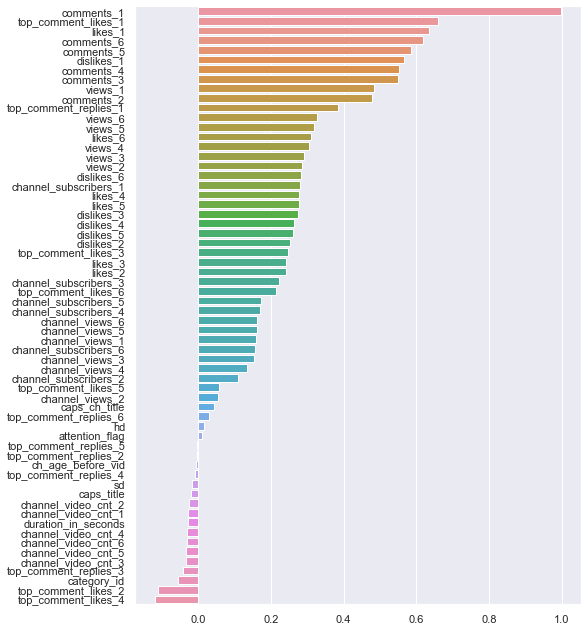

In [60]:
correlations_comments = X_train.corrwith(y_train["comments_7"]).sort_values(ascending=False)
plot_comments = sns.barplot(y=correlations_comments.index, x=correlations_comments)
plot_comments.figure.set_size_inches(8, 11)

В ходе экспериментов было выявлено, что лучшее качество модели достигается, если взять признаки с коэффициентом Пирсона не меньше 0.5.

Выделим наиболее важные признаки.

In [61]:
corr_df = pd.DataFrame(data={"features": correlations_comments.index, "importance": correlations_comments.values})
important_features = list(corr_df[np.abs(corr_df.importance) >= 0.25]["features"].values)
important_features

['comments_1',
 'top_comment_likes_1',
 'likes_1',
 'comments_6',
 'comments_5',
 'dislikes_1',
 'comments_4',
 'comments_3',
 'views_1',
 'comments_2',
 'top_comment_replies_1',
 'views_6',
 'views_5',
 'likes_6',
 'views_4',
 'views_3',
 'views_2',
 'dislikes_6',
 'channel_subscribers_1',
 'likes_4',
 'likes_5',
 'dislikes_3',
 'dislikes_4',
 'dislikes_5',
 'dislikes_2']

In [62]:
X = df[important_features]
y = df[target_dislikes]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

Подберём коэффициент регуляризации с помощью кросс-валидации.

In [63]:
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_std = scaler.fit_transform(X)
regr_cv = RidgeCV(alphas=list(np.arange(0.1, 10, 0.1)))
model_cv = regr_cv.fit(X_std, y)
cv_alpha = model_cv.alpha_

In [64]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

model = Ridge(alpha=cv_alpha)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))
print("Train RMSE = %.4f" % mean_squared_error(y_train, y_train_pred, squared=False))

Test RMSE = 92.9232
Train RMSE = 50.5589


Подберём коэффициент регуляризации по сетке с помощью кросс-валидации.

Best alpha = 0.6952


Text(0, 0.5, 'CV score')

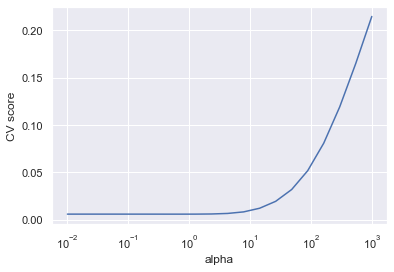

In [65]:
from sklearn.model_selection import GridSearchCV

alphas = np.logspace(-2, 3, 20)
searcher = GridSearchCV(Ridge(), [{"alpha": alphas}], scoring="neg_root_mean_squared_error", cv=10)
searcher.fit(X_train_scaled, y_train_scaled)

best_alpha = searcher.best_params_["alpha"]
print("Best alpha = %.4f" % best_alpha)

plt.plot(alphas, -searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score")

Попробуем улучшить качество модели, стандартизируя признаки и целевую переменную.

In [66]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train_scaled = scaler.fit_transform(y_train)
y_test_scaled = scaler.transform(y_test)

In [67]:
model = Ridge(alpha=best_alpha)
model.fit(X_train_scaled, y_train_scaled)
y_pred = model.predict(X_test_scaled)
y_train_pred = model.predict(X_train_scaled)

print("Test RMSE = %.4f" % mean_squared_error(y_test_scaled, y_pred, squared=False))
print("Train RMSE = %.4f" % mean_squared_error(y_train_scaled, y_train_pred, squared=False))
print("Test MSE = %.8f" % mean_squared_error(y_test_scaled, y_pred, squared=True))
print("Train MSE = %.8f" % mean_squared_error(y_train_scaled, y_train_pred, squared=True))

Test RMSE = 0.0063
Train RMSE = 0.0035
Test MSE = 0.00004015
Train MSE = 0.00001223


In [68]:
comments_model = model
comments_model

Ridge(alpha=0.6951927961775606, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [88]:
comments_model.coef_

array([[-6.37382177e-04, -1.76261748e-04,  8.02724106e-04,
        -9.64305217e-04,  5.51643011e-04,  9.00058998e-01,
        -9.34281466e-05,  1.68082412e-03, -9.12147004e-04,
        -7.95020005e-04,  4.94947326e-05,  3.26793126e-03,
         4.02971125e-03, -2.64198796e-03,  4.33670678e-04,
        -6.91858941e-03, -4.44112646e-04,  4.54390726e-02,
        -1.96242865e-04, -1.25056777e-02,  1.50595937e-02,
         3.44530456e-02,  4.09692077e-02,  3.67075658e-03,
         4.62073172e-02]])

Чтобы увидеть прогнозы, перейдём к исходной шкале.

In [57]:
y_inverse = scaler.inverse_transform(y_pred)

In [58]:
y_inverse

array([[  44.93624463],
       [1775.79528368],
       [3639.9940004 ],
       ...,
       [ 196.99729673],
       [  72.14680064],
       [ 595.16661811]])

In [59]:
y_inverse = np.int64(y_inverse)

In [60]:
r2_score(y_test, y_inverse)

0.9999376079642144

In [525]:
pd.DataFrame(y_inverse, columns=["comments_forecast"])

,comments_forecast
0,44
1,1775
2,3639
3,137
4,773
...,...
2254,167
2255,787
2256,196
2257,72


Получим предсказания просмотров по всем видео.

In [526]:
df_scaler = StandardScaler()
X_scaled = df_scaler.fit_transform(X)
y_scaled = df_scaler.fit_transform(y)

In [527]:
y_all_pred = comments_model.predict(X_scaled)
y_all_pred

array([[-0.12587916],
       [-0.13500995],
       [-0.16562535],
       ...,
       [-0.14872325],
       [-0.0412012 ],
       [ 0.09016306]])

In [528]:
y_all_pred.shape

(7528, 1)

In [529]:
y_inv = df_scaler.inverse_transform(y_all_pred)

In [530]:
pd.DataFrame(np.int64(y_inv), columns=["comments_forecast"])

,comments_forecast
0,647
1,522
2,102
3,275
4,96
...,...
7523,20
7524,1525
7525,334
7526,1808


In [531]:
forecast_ = pd.DataFrame(np.int64(y_inv), columns=["comments_forecast"])

In [532]:
forecast_["comments_forecast"].values

array([ 647,  522,  102, ...,  334, 1808, 3610])

In [533]:
df_copy = df.copy()
df_copy = df_copy.assign(comments_forecast=pd.Series(forecast_["comments_forecast"].values))

In [534]:
df_copy[["video_id", "comments_7", "comments_forecast"]].head(100)

,video_id,comments_7,comments_forecast
0,HfGRNUOqhLk,5500.0,647
1,Kk5naOEL3gQ,4064.0,522
2,4bKuBuPB_QA,134.0,102
3,eYOIhHu2gho,1581.0,275
4,0NDPSeDiYBI,325.0,96
...,...,...,...
95,GSmZlGwqv_8,2458.0,1735
96,nSJhOAVfgTE,1004.0,255
97,CMIndaI7Xfg,5385.0,759
98,EJDEhhN4stQ,36393.0,918


## Прогнозируем просмотры, лайки, дизлайки, комментарии

In [70]:
import pandas as pd

df = pd.read_csv("growth_df_btw_ids.tsv", sep='\t')
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

Среди всех столбцов выделяем признаки – все численные характеристики, кроме стастических показателей за 7 дней.

In [71]:
import numpy as np

numeric_data = df.select_dtypes([np.number])
numeric_features = numeric_data.columns

features = [item for item in numeric_features if item[-1] != '7']

In [72]:
features

['category_id',
 'views_1',
 'views_2',
 'views_3',
 'views_4',
 'views_5',
 'views_6',
 'likes_1',
 'likes_2',
 'likes_3',
 'likes_4',
 'likes_5',
 'likes_6',
 'dislikes_1',
 'dislikes_2',
 'dislikes_3',
 'dislikes_4',
 'dislikes_5',
 'dislikes_6',
 'comments_1',
 'comments_2',
 'comments_3',
 'comments_4',
 'comments_5',
 'comments_6',
 'channel_video_cnt_1',
 'channel_video_cnt_2',
 'channel_video_cnt_3',
 'channel_video_cnt_4',
 'channel_video_cnt_5',
 'channel_video_cnt_6',
 'channel_views_1',
 'channel_views_2',
 'channel_views_3',
 'channel_views_4',
 'channel_views_5',
 'channel_views_6',
 'channel_subscribers_1',
 'channel_subscribers_2',
 'channel_subscribers_3',
 'channel_subscribers_4',
 'channel_subscribers_5',
 'channel_subscribers_6',
 'top_comment_likes_1',
 'top_comment_likes_2',
 'top_comment_likes_3',
 'top_comment_likes_4',
 'top_comment_likes_5',
 'top_comment_likes_6',
 'top_comment_replies_1',
 'top_comment_replies_2',
 'top_comment_replies_3',
 'top_comment_repl

В зависимости от задачи (подзадачи) таргеты будут разными.

In [73]:
target_4 = ["views_7", "comments_7", "likes_7", "dislikes_7"]
target_views = ["views_7"]
target_likes = ["likes_7"]
target_dislikes = ["dislikes_7"]
target_comments = ["comments_7"]

In [74]:
from sklearn.model_selection import train_test_split

X = df[features]
y = df[target_4]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter("ignore")
%matplotlib inline

sns.set(style="darkgrid")

Для решения задачи хотелось бы обучить линейную регрессию, необходимо найти признаки, "наиболее линейно" связанные с целевой переменной, иначе говоря, посмотреть на коэффициент корреляции Пирсона между признаками и таргетом. Первостепенный показатель -- просмотры, поэтому будем отталкиваться от них.

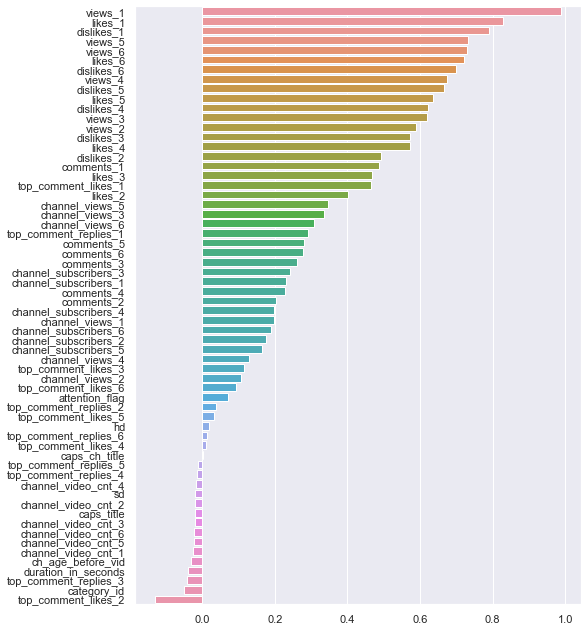

In [76]:
correlations_views = X_train.corrwith(y_train["views_7"]).sort_values(ascending=False)
plot_views = sns.barplot(y=correlations_views.index, x=correlations_views)
plot_views.figure.set_size_inches(8, 11)

В ходе экспериментов было выявлено, что лучшее качество модели достигается, если взять признаки с коэффициентом Пирсона не меньше 0.5.

Выделим наиболее важные признаки.

In [77]:
corr_df = pd.DataFrame(data={"features": correlations_views.index, "importance": correlations_views.values})
important_features = list(corr_df[np.abs(corr_df.importance) >= 0.2]["features"].values)
important_features

['views_1',
 'likes_1',
 'dislikes_1',
 'views_5',
 'views_6',
 'likes_6',
 'dislikes_6',
 'views_4',
 'dislikes_5',
 'likes_5',
 'dislikes_4',
 'views_3',
 'views_2',
 'dislikes_3',
 'likes_4',
 'dislikes_2',
 'comments_1',
 'likes_3',
 'top_comment_likes_1',
 'likes_2',
 'channel_views_5',
 'channel_views_3',
 'channel_views_6',
 'top_comment_replies_1',
 'comments_5',
 'comments_6',
 'comments_3',
 'channel_subscribers_3',
 'channel_subscribers_1',
 'comments_4',
 'comments_2']

In [78]:
X = df[important_features]
y = df[target_4]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

Подберём коэффициент регуляризации с помощью кросс-валидации.

In [79]:
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_std = scaler.fit_transform(X)
regr_cv = RidgeCV(alphas=list(np.arange(0.1, 10, 0.1)))
model_cv = regr_cv.fit(X_std, y)
cv_alpha = model_cv.alpha_

In [80]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.multioutput import MultiOutputRegressor

model = MultiOutputRegressor(Ridge(alpha=cv_alpha))
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))
print("Train RMSE = %.4f" % mean_squared_error(y_train, y_train_pred, squared=False))

Test RMSE = 20335.3789
Train RMSE = 13890.9405


Подберём коэффициент регуляризации по сетке с помощью кросс-валидации.

Best alpha = 0.6952


Text(0, 0.5, 'CV score')

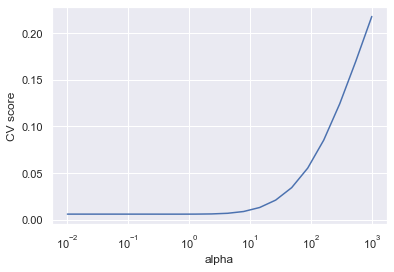

In [81]:
from sklearn.model_selection import GridSearchCV

alphas = np.logspace(-2, 3, 20)
searcher = GridSearchCV(Ridge(), [{"alpha": alphas}], scoring="neg_root_mean_squared_error", cv=10)
searcher.fit(X_train_scaled, y_train_scaled)

best_alpha = searcher.best_params_["alpha"]
print("Best alpha = %.4f" % best_alpha)

plt.plot(alphas, -searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score")

Попробуем улучшить качество модели, стандартизируя признаки и целевую переменную.

In [82]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train_scaled = scaler.fit_transform(y_train)
y_test_scaled = scaler.transform(y_test)

In [83]:
model = MultiOutputRegressor(Ridge(alpha=best_alpha))
model.fit(X_train_scaled, y_train_scaled)
y_pred = model.predict(X_test_scaled)
y_train_pred = model.predict(X_train_scaled)

print("Test RMSE = %.4f" % mean_squared_error(y_test_scaled, y_pred, squared=False))
print("Train RMSE = %.4f" % mean_squared_error(y_train_scaled, y_train_pred, squared=False))
print("Test MSE = %.8f" % mean_squared_error(y_test_scaled, y_pred, squared=True))
print("Train MSE = %.8f" % mean_squared_error(y_train_scaled, y_train_pred, squared=True))

Test RMSE = 0.0051
Train RMSE = 0.0032
Test MSE = 0.00002619
Train MSE = 0.00001023


In [84]:
target4_model = model
target4_model

MultiOutputRegressor(estimator=Ridge(alpha=0.6951927961775606, copy_X=True,
                                     fit_intercept=True, max_iter=None,
                                     normalize=False, random_state=None,
                                     solver='auto', tol=0.001),
                     n_jobs=None)

In [87]:
m = Ridge(alpha=best_alpha)
m.coef_

AttributeError: 'Ridge' object has no attribute 'coef_'

Чтобы увидеть прогнозы, перейдём к исходной шкале.

In [76]:
y_inverse = scaler.inverse_transform(y_pred)

In [77]:
y_inverse

array([[1.95555012e+05, 8.62147019e+00, 4.96907342e+02, 4.49895973e+01],
       [2.73790706e+06, 1.15515772e+04, 2.01059154e+05, 1.77921596e+03],
       [3.48458259e+06, 1.83365842e+03, 6.79754507e+04, 3.65283447e+03],
       ...,
       [1.72140029e+05, 1.67643747e+03, 1.49768805e+04, 1.96049746e+02],
       [8.40283276e+04, 2.94970521e+02, 2.19554220e+03, 7.23067585e+01],
       [3.85448930e+05, 1.31407716e+03, 3.73271365e+04, 5.94107169e+02]])

In [78]:
y_inverse = np.int64(y_inverse)

In [79]:
r2_score(y_test, y_inverse)

0.9999698817394376

In [557]:
pd.DataFrame(y_inverse, columns=["views_forecast", "comments_forecast", "likes_forecast", "dislikes_forecast"])

,views_forecast,comments_forecast,likes_forecast,dislikes_forecast
0,195494,8,494,44
1,2737771,11551,201064,1778
2,3482638,1835,67923,3651
3,1362762,333,6132,135
4,1029097,5180,24196,773
...,...,...,...,...
2254,640794,81,3976,167
2255,2101472,987,15024,788
2256,172065,1677,14977,196
2257,83960,294,2190,72


Получим предсказания просмотров по всем видео.

In [558]:
df_scaler = StandardScaler()
X_scaled = df_scaler.fit_transform(X)
y_scaled = df_scaler.fit_transform(y)

In [560]:
y_all_pred = target4_model.predict(X_scaled)
y_all_pred

array([[-0.14139173,  0.00658497,  0.17335234, -0.12582665],
       [-0.1134521 , -0.02905678, -0.1162154 , -0.13512372],
       [-0.25781223, -0.13991495, -0.25959595, -0.16559123],
       ...,
       [-0.21033123, -0.10607095, -0.25462503, -0.14872551],
       [-0.18058475, -0.07195754, -0.21505476, -0.04124171],
       [ 0.17254041,  0.01200367,  0.59344099,  0.09008216]])

In [561]:
y_all_pred.shape

(7528, 4)

In [562]:
y_inv = df_scaler.inverse_transform(y_all_pred)

In [563]:
pd.DataFrame(np.int64(y_inv), columns=["views_forecast", "comments_forecast", "likes_forecast", "dislikes_forecast"])

,views_forecast,comments_forecast,likes_forecast,dislikes_forecast
0,974326,5363,115691,648
1,1185283,4069,40069,520
2,95297,45,2625,103
3,482685,1418,7077,275
4,86706,211,2086,96
...,...,...,...,...
7523,58677,36,1101,21
7524,892401,1651,35264,1528
7525,453801,1273,3923,334
7526,678401,2512,14257,1808


In [564]:
forecast_ = pd.DataFrame(np.int64(y_inv), columns=["views_forecast", "comments_forecast", "likes_forecast", "dislikes_forecast"])

In [566]:
forecast_[["views_forecast", "comments_forecast", "likes_forecast", "dislikes_forecast"]].values

array([[ 974326,    5363,  115691,     648],
       [1185283,    4069,   40069,     520],
       [  95297,      45,    2625,     103],
       ...,
       [ 453801,    1273,    3923,     334],
       [ 678401,    2512,   14257,    1808],
       [3344659,    5560,  225398,    3609]])

In [573]:
df_copy = df.copy()
df_copy = df_copy.assign(views_forecast=pd.Series(forecast_["views_forecast"].values))
df_copy = df_copy.assign(comments_forecast=pd.Series(forecast_["comments_forecast"].values))
df_copy = df_copy.assign(likes_forecast=pd.Series(forecast_["likes_forecast"].values))
df_copy = df_copy.assign(dislikes_forecast=pd.Series(forecast_["dislikes_forecast"].values))

In [574]:
df_copy[["video_id", "views_7", "views_forecast", "likes_7", "likes_forecast", "dislikes_7", "dislikes_forecast", "comments_7", "comments_forecast"]].head(100)

,video_id,views_7,views_forecast,likes_7,likes_forecast,dislikes_7,dislikes_forecast,comments_7,comments_forecast
0,HfGRNUOqhLk,968037.0,974326,115973.0,115691,644.0,648,5500.0,5363
1,Kk5naOEL3gQ,1160808.0,1185283,40100.0,40069,524.0,520,4064.0,4069
2,4bKuBuPB_QA,88263.0,95297,2633.0,2625,110.0,103,134.0,45
3,eYOIhHu2gho,476710.0,482685,7065.0,7077,281.0,275,1581.0,1418
4,0NDPSeDiYBI,79032.0,86706,2072.0,2086,101.0,96,325.0,211
...,...,...,...,...,...,...,...,...,...
95,GSmZlGwqv_8,1440157.0,1436106,36521.0,36396,1744.0,1735,2458.0,2383
96,nSJhOAVfgTE,871583.0,873635,16278.0,16244,264.0,256,1004.0,874
97,CMIndaI7Xfg,1501513.0,1505768,24666.0,24668,764.0,759,5385.0,5151
98,EJDEhhN4stQ,2778546.0,2786285,987277.0,985284,907.0,903,36393.0,35748


In [585]:
df_copy.describe().duration_in_seconds

count     7528.000000
mean      1244.766605
std       2704.945760
min          3.000000
25%        208.000000
50%        560.000000
75%       1094.000000
max      42899.000000
Name: duration_in_seconds, dtype: float64

In [587]:
from scipy.stats import hmean

In [593]:
hmean(df_copy.loc[0, ["views_forecast", "likes_forecast", "dislikes_forecast", "comments_forecast"]].values)

2299.719257367983

1. Среднее геометрическое
2. Квантили с приоритетом от 1 до 4
3. Произведение 1 и 2
4. Шкала от 0 до 1
5. Сортировка по результату 4
6. Вывод первых n% от таблицы через head()